# Homework 1 - this is for all practical purposes a copy of hw2 from cs109a fall 2017
# Linear and k-NN Regression


---

### INSTRUCTIONS

- do the assignment in groups of three. Only one assignment must be submitted for the group.
- This does not mean that you are to divide and conquer. In the spirit of learning and getting the most out of this course, you should solve each problem on your own, compare with your partner, and decide on a common solution.
- Restart the kernel and run the whole notebook again before you submit. 
- Submit a printed copy of the assignment in the beginning of class October 1. Every class missed will result in a late penalty of 33%.
- Also send a zipped copy of all files(run ipython notebooks) to msjamall@iba.edu.pk. Use subject CS562: hw1; <group member 1's name>; <group member 2's name>; <group member 3's name>

---

Import libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

# Predicting Taxi Pickups in NYC

In this homework, we will explore k-nearest neighbor, linear and polynomial regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in files `dataset_1_train.txt` and `dataset_1_test.txt` as separate training and test sets. The first column in each file contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded during different days in Jan 2015 (randomly sampled across days and time of that day).

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pick ups at that time. The models will be fitted to the training set, and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric. 

**Data Normalization:** As a first step, we suggest that you normalize the `TimeMin` predictor to a value between 0 and 1. This can be done by dividing the time column in the training and test sets by 1440 (i.e. the maximum value the predictor can take). This normalization step would be particularly helpful while fitting polynomial regression models on this data.

# Part (0): EDA

Generate a scatter plot of the training data points, with the time of the day on the X-axis and the number of taxi pickups on the Y-axis. Does the pattern of taxi pickups make intuitive sense to you?

In [9]:
# Read in the csv files
dfTrain=pd.read_csv("dataset_1_train.txt")
dfTest=pd.read_csv("dataset_1_test.txt")

In [10]:
#dfTrain.shape
dfTrain.describe()

,TimeMin,PickupCount
count,250.000000,250.000000
mean,701.416000,32.780000
std,409.247928,18.910368
min,4.000000,1.000000
25%,381.500000,18.000000
50%,686.000000,32.000000
75%,1032.750000,44.000000
max,1438.000000,95.000000


In [11]:
dfTrain['Hour'] = (dfTrain.TimeMin // 60.0)
dfTrain['Minutes'] = (dfTrain.TimeMin % 60.0)
dfTrain['TimeNorm'] = (dfTrain.TimeMin / 1440.0)

dfTrain.head()

,TimeMin,PickupCount,Hour,Minutes,TimeNorm
0,860.0,33.0,14.0,20.0,0.597222
1,17.0,75.0,0.0,17.0,0.011806
2,486.0,13.0,8.0,6.0,0.337500
3,300.0,5.0,5.0,0.0,0.208333
4,385.0,10.0,6.0,25.0,0.267361


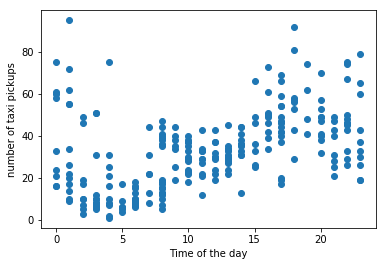

In [12]:
plt.scatter(dfTrain.Hour, dfTrain.PickupCount);
plt.xlabel("Time of the day");
plt.ylabel("number of taxi pickups");

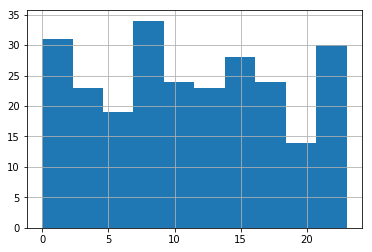

In [13]:
dfTrain.Hour.hist()

In [14]:
dfTest['Hour'] = (dfTest.TimeMin // 60.0)
dfTest['Minutes'] = (dfTest.TimeMin % 60.0)
dfTest['TimeNorm'] = (dfTest.TimeMin / 1440.0)
dfTest.head()

,TimeMin,PickupCount,Hour,Minutes,TimeNorm
0,925.0,43.0,15.0,25.0,0.642361
1,559.0,33.0,9.0,19.0,0.388194
2,1277.0,41.0,21.0,17.0,0.886806
3,1114.0,61.0,18.0,34.0,0.773611
4,784.0,29.0,13.0,4.0,0.544444


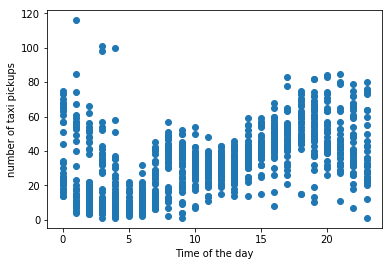

In [15]:
plt.scatter(dfTest.Hour, dfTest.PickupCount);
plt.xlabel("Time of the day");
plt.ylabel("number of taxi pickups");

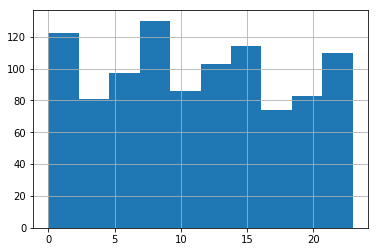

In [16]:
dfTest.Hour.hist()

# Part (a): k-Nearest Neighbors

We begin with k-Nearest Neighbors (k-NN), a non-parametric regression technique. You may use `sklearn`'s built-in functions to run k-NN regression. Create a `KNeighborsRegressor` object, use the `fit` method in the object to fit a k-NN regressor model, use the `predict` method to make predictions from the model, and the `score` method to evaluate the $R^2$ score of the model on a data set.

- Fit k-NN regression models:
    - Fit a k-NN regression model to the training set for different values of $k$ (e.g. you may try out values 1, 2, 10, 25, 50, 100 and 200). 
    - If you are using `sklearn`'s built-in functions for k-NN regression, explain what happens when you invoke the `fit` function. 
    - If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?
- Visualize the fitted models: 
    - Generate a scatter plot of the training data points, and in the same figure, also generate line plots of the predicted values $\hat{y}$ from each fitted model as a function of the predictor variable $x$. (*Hint:* you will want to sort the $x$ values before plotting.)
    - How does the value of $k$ effect the fitted model?
- Evaluate the fitted models:
    - Compute the $R^2$ score for the fitted models on both the training and test sets. Are some of the calculated $R^2$ values negative? If so, what does this indicate? What does a $R^2$ score of 0 mean?
    - Make plots of the training and test $R^2$ values as a function of $k$. Do the training and test $R^2$ plots exhibit different trends? Explain how the value of $k$ influences the training and test $R^2$ values.

In [17]:
y_train = dfTrain['PickupCount'].values.reshape(-1, 1)
x_train = dfTrain['TimeNorm'].values.reshape(-1, 1)

y_test = dfTest['PickupCount'].values.reshape(-1, 1)
x_test = dfTest['TimeNorm'].values.reshape(-1, 1)

In [18]:
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(x_train,y_train)

y_train_pred = knn_model.predict(x_train)
y_test_pred = knn_model.predict(x_test)

'The Fit method fits the model using X as training data (Normalized Time) and y as target values (Pickup Count)'

'The Fit method fits the model using X as training data (Normalized Time) and y as target values (Pickup Count)'

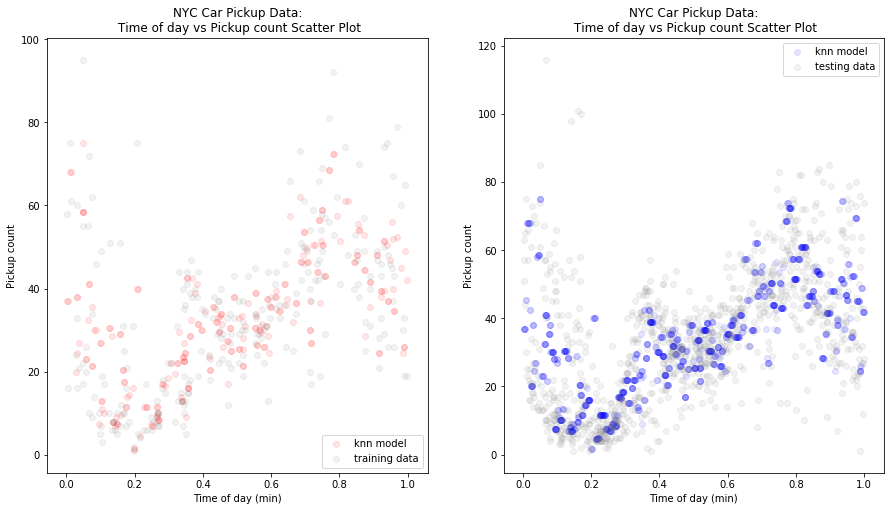

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].scatter(x_train, y_train_pred, color='red', alpha=0.1, label='knn model')
ax[0].scatter(x_train, y_train, color='gray', alpha=0.1, label='training data')

ax[0].set_xlabel('Time of day (min)')
ax[0].set_ylabel('Pickup count')
ax[0].set_title('NYC Car Pickup Data:\n Time of day vs Pickup count Scatter Plot')
ax[0].legend(loc='best')

ax[1].scatter(x_test, y_test_pred, color='blue', alpha=0.1, label='knn model')
ax[1].scatter(x_test, y_test, color='gray', alpha=0.1, label='testing data')

ax[1].set_xlabel('Time of day (min)')
ax[1].set_ylabel('Pickup count')
ax[1].set_title('NYC Car Pickup Data:\n Time of day vs Pickup count Scatter Plot')
ax[1].legend(loc='best')

In [20]:
train_MSE = mean_squared_error(y_train, y_train_pred)
test_MSE = mean_squared_error(y_test, y_test_pred)

print('The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE))

The train MSE is 126.297, the test MSE is 282.47575


In [21]:
k_values = [1, 2, 10, 25, 50, 100, 200]
train_MSEs = []
test_MSEs = []
train_R2 = []
test_R2 = []
y_train_pred_kth = 0
y_test_pred_kth = 0

for k in k_values:
#for k in range(1,100):
    knn_model_T = KNeighborsRegressor(n_neighbors=k)
    knn_model_T.fit(x_train, y_train)
    
    y_train_pred_kth = knn_model_T.predict(x_train)
    y_test_pred_kth = knn_model_T.predict(x_test)
    
    train_MSEs.append(mean_squared_error(y_train, y_train_pred_kth))
    test_MSEs.append(mean_squared_error(y_test, y_test_pred_kth))

    train_R2.append(r2_score(y_train, y_train_pred_kth))
    test_R2.append(r2_score(y_test, y_test_pred_kth))
    

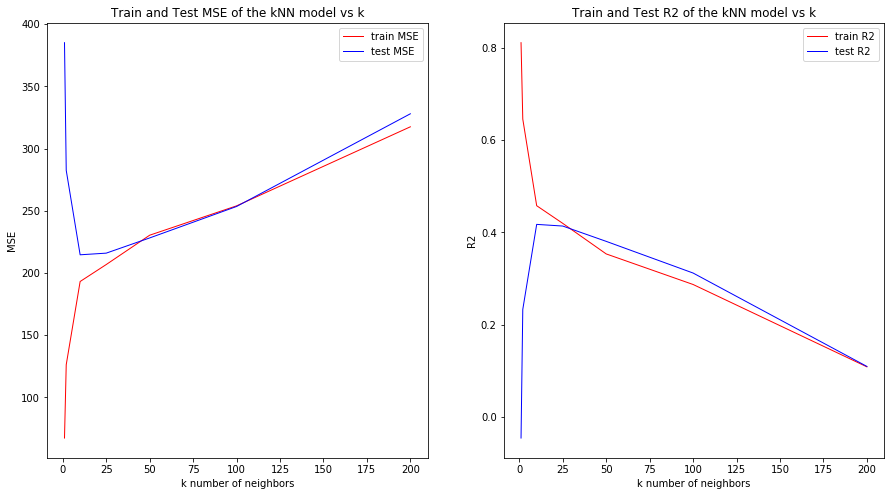

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot( k_values, train_MSEs, color='red', linewidth=1.0, label='train MSE')
ax[0].plot( k_values, test_MSEs, color='blue', linewidth=1.0, label='test MSE')

ax[0].set_xlabel('k number of neighbors')
ax[0].set_ylabel('MSE')
ax[0].set_title('Train and Test MSE of the kNN model vs k')
ax[0].legend(loc='best')


ax[1].plot( k_values, train_R2, color='red', linewidth=1.0, label='train R2')
ax[1].plot( k_values, test_R2, color='blue', linewidth=1.0, label='test R2')

ax[1].set_xlabel('k number of neighbors')
ax[1].set_ylabel('R2')
ax[1].set_title('Train and Test R2 of the kNN model vs k')
ax[1].legend(loc='best')

In [23]:
print(train_R2)

train_R2 = knn_model.score(y_train, y_train_pred)
test_R2 = knn_model.score(y_test, y_test_pred)

print('The train R2 is {}, the test R2 is {}'.format(train_R2, test_R2))
print('A R2 of 0 means that the model does not describe any of the variance of the response variable.')
print('A negative value of R2 means that the model produces results that are worst than simply using the mean for prediction')

[0.8108889086047287, 0.6454040692744734, 0.4577052184958037, 0.4194670658749883, 0.35325229524195634, 0.2870278573586439, 0.10863100988399976]
The train R2 is -0.382393577931, the test R2 is -0.298211722392
A R2 of 0 means that the model does not describe any of the variance of the response variable.
A negative value of R2 means that the model produces results that are worst than simply using the mean for prediction


# Part (b): Simple Linear Regression

We next consider parametric approaches for regression, starting with simple linear regression, which assumes that the response variable has a linear relationship with the predictor. Do you see any advantages in using a parametric regression model over k-NN regression?

    We suggest that you use the `statsmodels` module for linear regression. This module has built-in functions to summarize the results of regression, and to compute confidence intervals for estimated regression parameters. Create a `OLS` class instance, use the `fit` method in the instance for fitting a linear regression model, and use the `predict` method to make predictions. To include an intercept term in the regression model, you will need to append a column of 1's to the array of predictors using the `sm.add_constant` method. The `fit` method returns a `results` instance. Use the  `results.summary` method to obtain a summary of the regression fit, the `results.params` attribute to get the estimated regression parameters, and the `conf_int` method to compute confidence intervals for the estimated parameters. You may use the `r2_score` function to compute $R^2$.

Using the suggested built-in functions, answer the following questions:

- Fit a linear regression model to the training set, and evaluate its $R^2$ value on both the training and test sets (you may notice something peculiar about how they compare). 
- How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression in Part (a)?

- Compute confidence intervals:
    - Print the slope and intercept values for the fitted linear model. What does the sign of the slope convey about the data?
    - Compute the 95% confidence interval for the slope and intercept. Based on this information, do you consider the estimates of the model parameters to be reliable?
    - Do you expect a 99% confidence interval for the slope and intercept to be tighter or looser than the 95% confidence intervals? Briefly explain your answer.

- Analyze residual plots:
    - Make a plot of the residuals ${e} = y - \hat{y}$ of the model on the training set as a function of the predictor variable $x$ (i.e. time of day). Draw a horizontal line denoting the zero residual value on the Y-axis.
    - Using this residual plot, comment on whether the assumption of linearity is valid for this data.

In [28]:
x_train_L = sm.add_constant(x_train)
x_test_L = sm.add_constant(x_test)

ols_model = sm.OLS(y_train, x_train_L)
ols_model_result = ols_model.fit()

y_train_pred = ols_model_result.fittedvalues.reshape(-1, 1)
y_test_pred = ols_model_result.predict(x_test_L)

ols_train_R2 = ols_model_result.rsquared
ols_test_R2 = r2_score(y_test, y_test_pred)

print('The train R2 is {}, the test R2 is {}'.format(ols_train_R2, ols_test_R2))

print('The Linear Regression R2 is worst than the k-NN regression R2.')

The train R2 is 0.207213752099, the test R2 is 0.247712329948
The Linear Regression R2 is worst than the k-NN regression R2.


In [29]:
# Linear regression equation -> y = a + bx 
# y = response / dependant variable 
# x = predictor / independent variable
# a = intercept (the value of y when x = 0)
# b = slope

slope = ols_model_result.params[0]
intercept = ols_model_result.params[1]

# this is the estimated statistical model (f_hat) using the predicted coefficients 
regression_line = lambda x: intercept + slope * x

print('The estimated equation of the regression line is: {} + {} * x'.format(intercept, slope))
print('The slope is {} and the intercept is {}.'.format(slope, intercept))
print('The slope shows that for each one-point unit in predictor variable, the response variable increases by {}.'.format(slope))

The estimated equation of the regression line is: 30.2890229863 + 18.0263851757 * x
The slope is 18.0263851757 and the intercept is 30.2890229863.
The slope shows that for each one-point unit in predictor variable, the response variable increases by 18.0263851757.


In [30]:
print(ols_model_result.summary())
print('Two-tail p-values test the hypothesis that each coefficient is different from 0. To reject this, the p-value has to be lower than 0.05. The slope and intercept both have some significant impact on Y (its coefficient is different from 0) ')
print('The confidence interval of 99% would be tighter as the t-value are almost the same.')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     64.82
Date:                Mon, 01 Oct 2018   Prob (F-statistic):           3.43e-14
Time:                        14:38:54   Log-Likelihood:                -1060.1
No. Observations:                 250   AIC:                             2124.
Df Residuals:                     248   BIC:                             2131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.0264      2.121      8.501      0.0

The residual plot shows a random pattern which supports the assumption that linearity is valid for this data


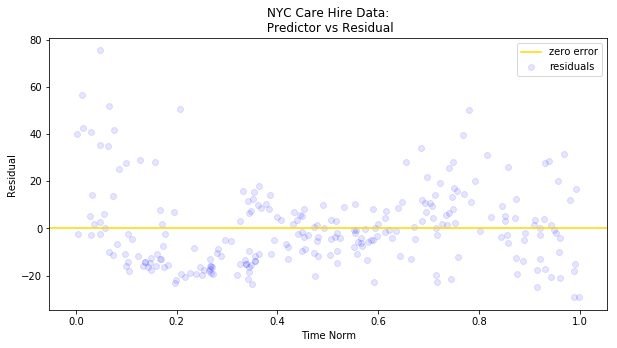

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

errorss = np.subtract(y_train, y_train_pred)
ax.scatter(x_train, errorss, color='blue', alpha=0.1, label='residuals')
ax.axhline(y=0, color='gold', label='zero error')

ax.set_xlabel('Time Norm')
ax.set_ylabel('Residual')
ax.set_title('NYC Care Hire Data:\n Predictor vs Residual')
ax.legend(loc='best')

print('The residual plot shows a random pattern which supports the assumption that linearity is valid for this data')

# Part (c): Polynomial Regression

We proceed to higher-order polynomial models for regression:

- By visual inspection, what polynomial degree do you think would provide the best fit for the data?

- At the start of this assignment, we had advised you to normalize the time predictor in the training and test sets to a value in [0,1], and noted that this would be helpful in fitting polynomial regression models. Had the time predictor not been normalized, what difficulties in implementing polynomial regression may have occurred?

- Fit polynomial regression models of degrees 2, 3, 10, 25 and 50 to the training set, and generate visualizations of the fitted models (in the same figure, plot the predicted value from all models as a function of time). 

- Evaluate the $R^2$ value of the fitted models on both the training and test sets. Does a high training $R^2$ value necessarily indicate a high test $R^2$ value? How do the test $R^2$ values from the different polynomial models compare with the test $R^2$ from simple linear regression in Part (b), and the best test $R^2$ from k-NN regression in Part (a)?

- Generate residual plots for the different polynomial regression models (plot of residuals on training set vs. time). How does the increase in polynomial degree effect the residual plots?

*Hint:* You may use the `PolynomialFeatures` class to include polynomial terms in the regression model.

In [56]:
poly_reg_models = []
poly_reg_range = [2,3,10,25,50]
train_R_sq = []
test_R_sq = []
#print(x_train)

for d in poly_reg_range:
    #print(d)
    x_train_with_poly = PolynomialFeatures(degree=d, interaction_only=False).fit_transform(x_train)
    #print(x_train_with_poly)
    ols_reg_model = sm.OLS(y_train, x_train_with_poly)
    ols_reg_model_result = ols_model.fit()
    print(ols_reg_model_result.rsquared)
    #poly_reg_models.append(ols_reg_model_result)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

errorss = np.subtract(y_train, y_train_pred)
ax.scatter(x_train, errorss, color='blue', alpha=0.1, label='residuals')
ax.axhline(y=0, color='gold', label='zero error')

ax.set_xlabel('Time Norm')
ax.set_ylabel('Residual')
ax.set_title('NYC Care Hire Data:\n Predictor vs Residual')
ax.legend(loc='best')

print('The residual plot shows a random pattern which supports the assumption that linearity is valid for this data')

0.20721375209894022
0.20721375209894022
0.20721375209894022
0.20721375209894022
0.20721375209894022


In [76]:
x_2 = PolynomialFeatures(degree=2, interaction_only=False).fit_transform(x_train)
x_3 = PolynomialFeatures(degree=3, interaction_only=False).fit_transform(x_train)
x_10 = PolynomialFeatures(degree=10, interaction_only=False).fit_transform(x_train)
x_25 = PolynomialFeatures(degree=25, interaction_only=False).fit_transform(x_train)
x_50 = PolynomialFeatures(degree=50, interaction_only=False).fit_transform(x_train)

x_2_model = sm.OLS(x_2, y_train)
x_2_model_results = ols_model.fit()
print(x_2_model_results.rsquared)

x_3_model = sm.OLS(y_train, x_3)
x_3_model_results = ols_model.fit()

x_10_model = sm.OLS(y_train, x_10)
x_10_model_results = ols_model.fit()

x_25_model = sm.OLS(y_train, x_25)
x_2_model_results = ols_model.fit()

x_50_model = sm.OLS(y_train, x_50)
x_50_model_results = ols_model.fit()

0.20721375209894022


The residual plot shows a random pattern which supports the assumption that linearity is valid for this data


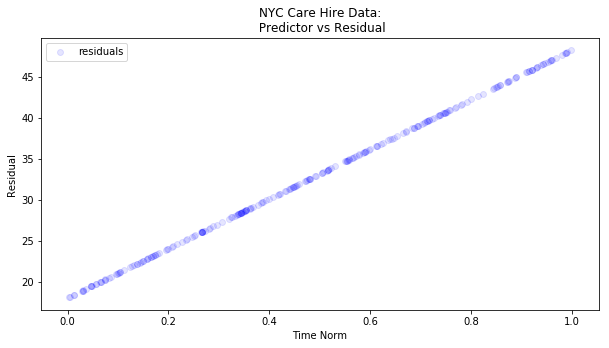

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.scatter(x_train, x_2_model_results.fittedvalues.reshape(-1, 1), color='blue', alpha=0.1, label='residuals')

ax.set_xlabel('Time Norm')
ax.set_ylabel('Residual')
ax.set_title('NYC Care Hire Data:\n Predictor vs Residual')
ax.legend(loc='best')

print('The residual plot shows a random pattern which supports the assumption that linearity is valid for this data')

The residual plot shows a random pattern which supports the assumption that linearity is valid for this data


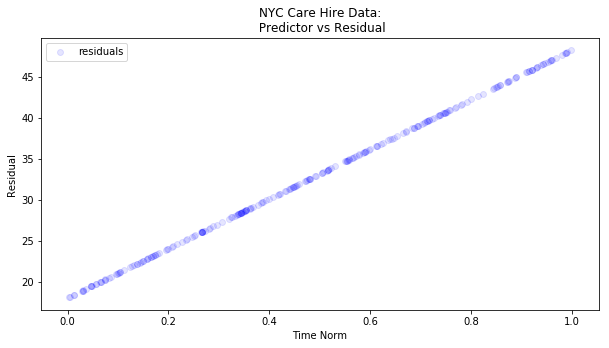

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.scatter(x_train, x_3_model_results.fittedvalues.reshape(-1, 1), color='blue', alpha=0.1, label='residuals')

ax.set_xlabel('Time Norm')
ax.set_ylabel('Residual')
ax.set_title('NYC Care Hire Data:\n Predictor vs Residual')
ax.legend(loc='best')

print('The residual plot shows a random pattern which supports the assumption that linearity is valid for this data')

The residual plot shows a random pattern which supports the assumption that linearity is valid for this data


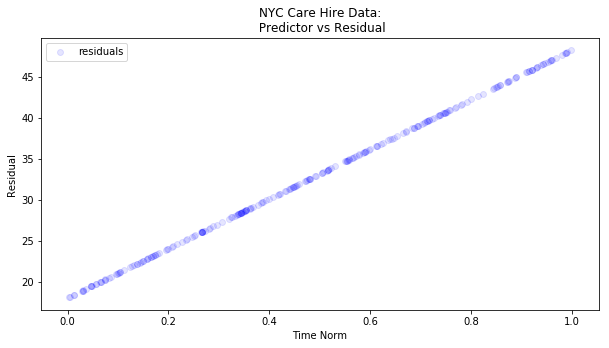

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.scatter(x_train, x_10_model_results.fittedvalues.reshape(-1, 1), color='blue', alpha=0.1, label='residuals')

ax.set_xlabel('Time Norm')
ax.set_ylabel('Residual')
ax.set_title('NYC Care Hire Data:\n Predictor vs Residual')
ax.legend(loc='best')

print('The residual plot shows a random pattern which supports the assumption that linearity is valid for this data')

In [ ]:
gen_poly_terms = PolynomialFeatures(degree=2, interaction_only=False)
X_train_with_poly = gen_poly_terms.fit_transform(x_train)
X_test_with_poly = gen_poly_terms.fit_transform(x_test)

poly_regression_model = LinearRegression(fit_intercept=True)
poly_regression_model.fit(X_train_with_poly, y_train)

train_MSE= np.mean((y_train - poly_regression_model.predict(X_train_with_poly))**2)
test_MSE= np.mean((y_test - poly_regression_model.predict(X_test_with_poly))**2)
print('The train MSE for degree 2 poly model is {}, the test MSE is {}'.format(train_MSE, test_MSE))

train_R_sq = poly_regression_model.score(X_train_with_poly, y_train)
test_R_sq = poly_regression_model.score(X_test_with_poly, y_test)
print('The train R^2 for degree 2 poly model is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq))

# Part (d): Summarize Results
In a brief paragraph (8 or fewer sentences), summarize which of the models seen above you would choose to predict the number of taxi cab pick-ups at any specific time of day.  Be sure to explain your choice. Interpret the model you choose, including which predictors are significant and provide and interpret the CIs for their coefficients (if you choose a regression model). How well does you model predict the number of taxi cab pick-ups?  How would you improve this model even further?  Feel free to refer to visual(s) above or provide a new one to make your case.



---- 
